<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4467/logos/front_page.png", style="float:left;width:100px;height:50px;">

<img src="https://kaggle2.blob.core.windows.net/competitions/kaggle/4467/media/dozer.png", style="float:left;width:400px;height:200px;">

- 건설 장비 업체. 각종 장비에 들어가는 tubing 의 가격 예측 모델 만들기
- 평가: RMSLE (Root Mean Squared Logarithmic Error)
- [kaggle link](https://www.kaggle.com/c/caterpillar-tube-pricing)

### 0. 주제 선정 이유 및 Data 보기 전 가설 수립
(주제 선정 이유) 
  * 계약 담당했던 시추 장비 pkg.에도 많은 배관재가 포함되어 있었음. 
  * 구매 경험 했던 사람으로서 기존 가격 정보를 가지고 예측을 해본다는 주제에 관심이 갔음
  
(tube 견적에 영향을 미칠만한 요인은?)
  - 원자재(구리) 가격
  - tube의 size(length, radius), thickness
  - tube의 재질 (특이재질 titanum 등 가공이 어렵고 비쌈)
  - 주문량 많을 수록 단가 낮아질 것
  - vendor 의 규모, 가격협상력 등에 따라

In [1]:
# 기본 tool
import pandas as pd 
import numpy as np
import time
#시각화
from matplotlib import pyplot as plt
import seaborn as sns 
# 전처리
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
# PCA
from sklearn.decomposition import PCA 
from sklearn.preprocessing import scale
# validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb 
from xgboost.sklearn import XGBRegressor
%matplotlib inline 

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 1. Data Import

In [2]:
train = pd.read_csv('./input/train_set.csv', parse_dates=[2,]) # parse_datas: 연-월-일로 되어 있는 data를 분리하기 위해 
test = pd.read_csv('./input/test_set.csv', parse_dates=[3,])
tube_data = pd.read_csv('./input/tube.csv')
bill_of_materials_data = pd.read_csv('./input/bill_of_materials.csv')
specs_data = pd.read_csv('./input/specs.csv')

In [3]:
def info(dataset):
    print("* shape of dataset")
    print(dataset.shape)
    print("------------------------------------------")
    print("* columns:")
    print(dataset.columns)
    print("------------------------------------------")
    print("* brief information of dataframe:")
    print(dataset.info())

### 2. Data Cleaning

#### (1) Dataframe 재정의

In [4]:
train_df = pd.merge(train, tube_data, on ='tube_assembly_id')
train_df = pd.merge(train_df, bill_of_materials_data, on ='tube_assembly_id')

In [5]:
test_df = pd.merge(test, tube_data, on ='tube_assembly_id')
test_df = pd.merge(test_df, bill_of_materials_data, on ='tube_assembly_id')

예측해야할 종속변수 price를 분리하고, quote_date 변수 year, month로 분리

In [6]:
train_df['year'] = train_df.quote_date.dt.year
train_df['month'] = train_df.quote_date.dt.month

In [7]:
df_y = train_df.iloc[:, 7].copy()
train_df = train_df.drop(['quote_date'], axis = 1)

test에서 id를 별도 Series로 분리해두고, quote_date 변수 year와 month로 변환해줌

In [8]:
test_id = test.iloc[:, 0].copy()

In [9]:
test_df['year'] = test_df.quote_date.dt.year
test_df['month'] = test_df.quote_date.dt.month
test_df = test_df.drop(['id', 'quote_date'], axis = 1)

#### (2) Preprocessing

#### a. 결측값 제거

category 변수는 supplier, bracket_pricing, material_id, end_, component_id 총 17개 존재함.  
- material_id 229개 누락 -> SP-0029에 비하면 적은 양이나, 약 1%의 비중을 차지하는 부분임. 임의의 SP-9999 번호 부여
- component_id_1~8까지에 결측값(NaN)이 존재. -> 공란으로 채워줌

In [12]:
train_df['material_id'].fillna('SP-9999', inplace = True)

In [13]:
test_df['material_id'].fillna('SP-9999', inplace = True)

In [14]:
for i in range(1,9):
    col_num = 'component_id_' + str(i)
    train_df[col_num].replace(np.nan,' ', regex=True, inplace= True)

In [15]:
for i in range(1,9):
    col_num = 'component_id_' + str(i)
    test_df[col_num].replace(np.nan,' ', regex=True, inplace= True)

양적 변수 중 각 component의 quantity에도 결측값 존재. -> 이는 사용되지 않았다는 의미로 0으로 채워줌

In [16]:
train_df.fillna(0, inplace = True)

In [17]:
test_df.fillna(0, inplace = True)

#### b. Label Encoding, Onehot Encoding

- catergory 변수 중 bracket_pricing, end_a_1x, end_a_2x, end_x_1x, end_x_2x (5개)는 Y/N 이므로 Label Encoder를 활용해 0, 1로 변환

In [18]:
le = LabelEncoder()

In [19]:
# numpy array 형태로 변환
np_train_df = np.array(train_df)

In [20]:
np_test_df = np.array(test_df)

In [21]:
train_df.columns

Index(['tube_assembly_id', 'supplier', 'annual_usage', 'min_order_quantity',
       'bracket_pricing', 'quantity', 'cost', 'material_id', 'diameter',
       'wall', 'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x',
       'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket',
       'other', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2',
       'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4',
       'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6',
       'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8', 'year',
       'month'],
      dtype='object')

In [22]:
test_df.columns

Index(['tube_assembly_id', 'supplier', 'annual_usage', 'min_order_quantity',
       'bracket_pricing', 'quantity', 'material_id', 'diameter', 'wall',
       'length', 'num_bends', 'bend_radius', 'end_a_1x', 'end_a_2x',
       'end_x_1x', 'end_x_2x', 'end_a', 'end_x', 'num_boss', 'num_bracket',
       'other', 'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2',
       'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4',
       'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6',
       'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8', 'year',
       'month'],
      dtype='object')

In [23]:
# bracket_pricing, end_a_1x, end_a_2x, end_x_1x, end_x_2x 변환
for i in range(np_train_df.shape[1]):
    if i in [4, 13, 14, 15, 16]:
        np_train_df[:, i] = le.fit_transform(np_train_df[:,i])

In [24]:
for i in range(np_test_df.shape[1]):
    if i in [4, 12, 13, 14, 15]:
        np_test_df[:, i] = le.fit_transform(np_test_df[:,i])

In [25]:
le_train_df = pd.DataFrame(np_train_df)

In [26]:
le_train_df.columns = train_df.columns

In [27]:
le_test_df = pd.DataFrame(np_test_df)
le_test_df.columns = test_df.columns

- category 변수 중 supplier, material_id value가 여러가지 이므로 dummy화 해준다.

In [28]:
dum_sup_col = ['supplier']
dum_mat_col = ['material_id']

dum_sup = pd.get_dummies(le_train_df[dum_sup_col])
dum_mat = pd.get_dummies(le_train_df[dum_mat_col])

In [29]:
dum_sup_t = pd.get_dummies(le_test_df[dum_sup_col])
dum_mat_t = pd.get_dummies(le_test_df[dum_mat_col])

- category 변수 중 tube_assembly_id는 end_a/x 여부, end_a/x에 어떤 componenet가 들어가는지, component_id와 quantity를 포함하는 변수. 다름을 나타냄

In [32]:
le_train_df['tube_assembly_id']= le_train_df['tube_assembly_id'].str[3:]

In [33]:
le_test_df['tube_assembly_id']= le_test_df['tube_assembly_id'].str[3:]

In [34]:
tube_col = ['end_a_1x', 'end_a_2x', 'end_x_1x', 'end_x_2x', 'end_a', 'end_x',
            'component_id_1', 'quantity_1', 'component_id_2', 'quantity_2', 
            'component_id_3', 'quantity_3', 'component_id_4', 'quantity_4', 
            'component_id_5', 'quantity_5', 'component_id_6', 'quantity_6', 
            'component_id_7', 'quantity_7', 'component_id_8', 'quantity_8']
le_train_df = le_train_df.drop(tube_col, axis=1)

In [35]:
le_test_df= le_test_df.drop(tube_col, axis=1)

dummy화 시킨 'supplier', 'material_id'을 단순화 (차원 축소 by PCA)

In [36]:
pca = PCA()

In [37]:
def pca_df(df):
    pca.fit(df)
    var = pca.explained_variance_ratio_
    cum_var = np.cumsum(np.round(var, decimals=4)*100)
    plt.plot(cum_var)
    #print(cum_var)
    i = 0
    while i < len(cum_var):
        if cum_var[i] >= 90: 
            print('{}ea: {}%'.format(i, cum_var[i]))
            break
        elif cum_var[i] < 95:
            i = i + 1


5ea: 90.48%


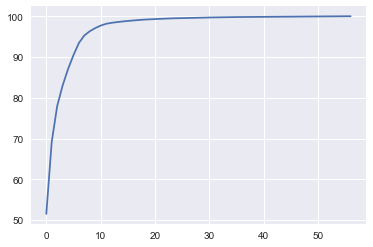

In [38]:
pca_df(dum_sup)

In [39]:
# column 수 맞춰주기 위해 
dum_sup_t['supplier_S-0003'] = pd.Series(0)

In [40]:
dum_sup_t= dum_sup_t.fillna(0)

In [41]:
pca = PCA(n_components=5)
pca.fit(dum_sup)
pca_dum_sup = pca.transform(dum_sup)
pca_dum_sup_t = pca.transform(dum_sup_t)

3ea: 92.97%


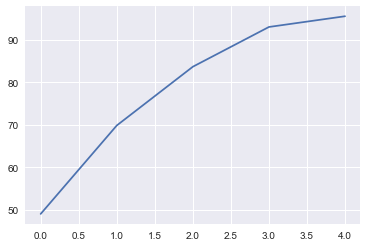

In [42]:
pca_df(dum_mat)

In [43]:
# column 수 맞춰주기 위해 
dum_mat_t['material_id_SP-0031'] = pd.Series(0)
dum_mat_t= dum_mat_t.fillna(0)

In [44]:
pca = PCA(n_components=3)
pca.fit(dum_mat)
pca_dum_mat = pca.transform(dum_mat)
pca_dum_mat_t = pca.transform(dum_mat_t)

In [45]:
dum_sup = pd.DataFrame(pca_dum_sup)
dum_mat = pd.DataFrame(pca_dum_mat)

In [46]:
dum_sup_t = pd.DataFrame(pca_dum_sup_t)
dum_mat_t = pd.DataFrame(pca_dum_mat_t)

In [47]:
pca_dum = pd.concat([dum_sup, dum_mat], axis = 1)
pca_dum.shape

(30213, 8)

In [48]:
pca_dum.tail()

,0,1,2,3,4,0,1,2
30208,0.924167,-0.612549,-0.181750,0.015030,-0.018890,0.816077,-0.543056,-0.023822
30209,0.924167,-0.612549,-0.181750,0.015030,-0.018890,0.816077,-0.543056,-0.023822
30210,0.924167,-0.612549,-0.181750,0.015030,-0.018890,-0.516131,-0.070568,-0.005238
30211,0.560890,0.138204,0.320472,-0.073232,0.137242,-0.516131,-0.070568,-0.005238
30212,0.596372,0.169681,0.550864,-0.658749,-0.546707,-0.516131,-0.070568,-0.005238


In [49]:
pca_dum.columns = range(8)

In [50]:
pca_dum_t = pd.concat([dum_sup_t, dum_mat_t], axis = 1)

In [51]:
pca_dum_t.columns = range(8)

In [52]:
le_train_df.drop(dum_sup_col, inplace= True, axis = 1)
le_train_df.drop(dum_mat_col, inplace= True, axis = 1)

In [53]:
le_test_df.drop(dum_sup_col, inplace= True, axis = 1)
le_test_df.drop(dum_mat_col, inplace= True, axis = 1)

In [54]:
processed_train_df = pd.concat([le_train_df, pca_dum], axis=1)
processed_train_df.shape

(30213, 24)

In [55]:
processed_test_df = pd.concat([le_test_df, pca_dum_t], axis=1)
processed_test_df.shape

(30235, 23)

#### c. outlier 제거

EDA에서 확인한 length 0, bend_radius 9999 전처리

In [56]:
processed_train_df['length'].value_counts().sort_index().head()

0.0    26
1.0     8
3.0     1
4.0    23
5.0     3
Name: length, dtype: int64

In [57]:
processed_train_df = processed_train_df.loc[processed_train_df['length'] > 0]

In [58]:
processed_train_df['bend_radius'].value_counts().sort_index().tail()

203.2     16
228.6      1
254.0     21
530.0      8
9999.0    12
Name: bend_radius, dtype: int64

In [59]:
processed_train_df = processed_train_df.loc[processed_train_df['bend_radius'] < 9999]

- 종속변수 cost 별도의 dataframe으로 분리

In [60]:
df_y = processed_train_df['cost'].copy()

In [79]:
processed_train_df = processed_train_df.drop(['cost'], axis=1)

model 학습을 위해 numeric 변수로 변환

In [80]:
fin_train_df = processed_train_df.apply(pd.to_numeric)
df_y = df_y.apply(pd.to_numeric)

In [81]:
fin_train_df.columns

Index([  'tube_assembly_id',       'annual_usage', 'min_order_quantity',
          'bracket_pricing',           'quantity',           'diameter',
                     'wall',             'length',          'num_bends',
              'bend_radius',           'num_boss',        'num_bracket',
                    'other',               'year',              'month',
                          0,                    1,                    2,
                          3,                    4,                    5,
                          6,                    7],
      dtype='object')

In [75]:
fin_test.columns

Index([  'tube_assembly_id',       'annual_usage', 'min_order_quantity',
          'bracket_pricing',           'quantity',           'diameter',
                     'wall',             'length',          'num_bends',
              'bend_radius',           'num_boss',        'num_bracket',
                    'other',               'year',              'month',
                          0,                    1,                    2,
                          3,                    4,                    5,
                          6,                    7],
      dtype='object')

In [82]:
fin_test = processed_test_df.apply(pd.to_numeric)

In [83]:
# for RMSLE
log_df_y = np.log1p(df_y) 

In [109]:
fin_train_df.to_csv('my_train.csv', header = True, index = False)
log_df_y.to_csv('my_log_df_y.csv', header = True, index = False)
fin_test.to_csv('my_test.csv', header = True, index = False)